In [1]:
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfPipeline
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig, ADDataManager
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.models.neurad import NeuRADModelConfig

In [2]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/gasparyanartur/dev/neurad-studio


In [4]:
from dataclasses import asdict

from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

config=DiffusionNerfConfig(
        max_steps=20001,
        calc_fid_steps=tuple(range(0, 20001, 5000)),
        ray_patch_size=(128, 128),
        datamanager=ADDataManagerConfig(
            train_num_lidar_rays_per_batch=16384,
            eval_num_lidar_rays_per_batch=16384,
            dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",)),
            num_processes=0
        ),
        model=NeuRADModelConfig(
            eval_num_rays_per_chunk=1 << 15,
            camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
            rgb_upsample_factor=4,
        ),
        diffusion_model=DiffusionModelConfig(),
        augment_phase_step=0,
        augment_strategy="none",
    )


In [7]:
import torch


device = torch.device("cuda")
pipe = DiffusionNerfPipeline(config, device=device)

Output()

Output()

Setting up evaluation dataset...
Caching all 40 images.


Output()

Caching all 40 images.


Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
pipe.datamanager

ADDataManager(
  (train_lidar_ray_generator): LidarRayGenerator()
  (train_ray_generator): RayGenerator()
  (eval_ray_generator): RayGenerator()
  (eval_lidar_ray_generator): LidarRayGenerator()
)

In [9]:
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision.transforms as tvtf

from nerfstudio.cameras.cameras import Cameras

torch.Size([512, 512, 3])


/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


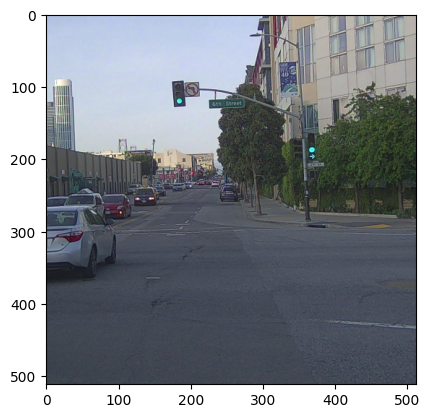

In [39]:
img_transform = tvtf.Compose((tvtf.ConvertImageDtype(torch.float32), tvtf.CenterCrop((1024, 1024)), tvtf.Resize((512, 512))))

ex_img = pipe.datamanager.train_dataset.get_image_float32(0).permute(2, 0, 1)
ex_img = img_transform(ex_img).permute(1, 2, 0)

print(ex_img.shape)
plt.imshow(ex_img)

In [40]:
sd_pipe = load_diffusion_model({"model_name": "sd_base", "model_id": ModelId.sd_v2_1, "low_mem_mode": True})
#pipe = load_diffusion_model({"model_name": "mock"})

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([512, 512, 3])
torch.Size([1, 512, 512, 3])


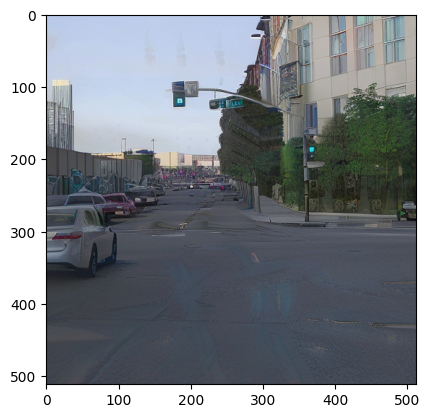

In [46]:
print(ex_img.shape)
ex_out = sd_pipe.get_diffusion_output({"rgb": ex_img})
print(ex_out["rgb"].shape)
plt.imshow(ex_out["rgb"][0].cpu().float())

In [83]:
ray_bundle, batch = pipe.datamanager.next_train(0)
cameras = pipe.datamanager.train_dataset.cameras

In [84]:
is_cam = ~ray_bundle.metadata["is_lidar"].flatten()
orig = ray_bundle.origins[is_cam].cpu()
dirs = ray_bundle.directions[is_cam].cpu()
cam_to_worlds = cameras.camera_to_worlds[ray_bundle.camera_indices[is_cam].cpu()]

In [88]:
print(orig.mean(dim=0), orig.std(dim=0))
print(dirs.mean(dim=0), dirs.std(dim=0))

tensor([-0.3255,  4.5555, -0.1719]) tensor([0.3332, 2.4631, 0.1399])
tensor([-0.3128,  0.7263, -0.0835]) tensor([0.5431, 0.2424, 0.1182])


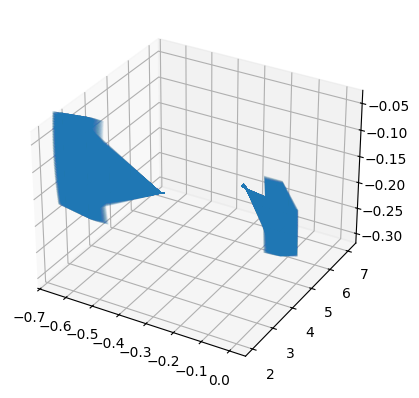

In [89]:
fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()
ax.quiver(
    orig[:, 0],
    orig[:, 1],
    orig[:, 2],
    dirs[:, 0],
    dirs[:, 1],
    dirs[:, 2],
    length=0.5,
    linewidths=0.01,
)

plt.show()

In [81]:
# 90 degree shift should reflect on image


In [158]:


 
def make_cam_matrix(rotation, translation):
    return torch.cat((rotation, translation[..., None]), dim=-1)[None, ...]

In [159]:
v = torch.tensor([1, 0, 0]).float().T

print(rotate_around(torch.pi/2, 0) @ v, rotate_around(torch.pi/2, 1) @ v, rotate_around(torch.pi/2, 2) @ v)
print(rotate_around(torch.pi/2, 0) @ rotate_around(torch.pi/2, 1) @ rotate_around(torch.pi/2, 2) @ v)
print(rotate_around(torch.pi/2, 2) @ rotate_around(torch.pi/2, 1) @ rotate_around(torch.pi/2, 0) @ v)

tensor([1., 0., 0.]) tensor([-4.3711e-08,  0.0000e+00, -1.0000e+00]) tensor([-4.3711e-08,  1.0000e+00,  0.0000e+00])
tensor([ 1.9107e-15, -8.7423e-08,  1.0000e+00])
tensor([ 1.9107e-15, -4.3711e-08, -1.0000e+00])


In [160]:
v1 = torch.tensor([1, 0, 0, 0]).float().T
vs = []
n_vs = 8
for i in range(n_vs):
    theta = 2 * i * torch.pi / n_vs 
    flip_cam = make_cam_matrix(rotate_around(theta, 2), torch.zeros(3))
    v = (flip_cam @ v1).flatten()
    vs.append(v)

dirs = torch.stack(vs)
origs = torch.zeros_like(dirs)

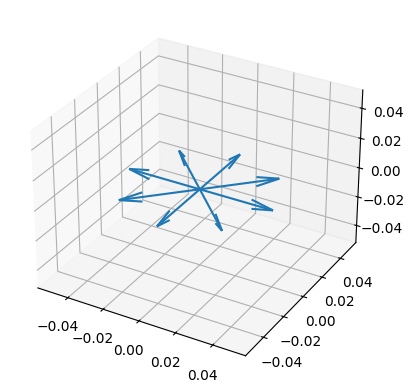

In [161]:
fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()

ax.quiver(
    origs[:, 0],
    origs[:, 1],
    origs[:, 2],
    dirs[:, 0], 
    dirs[:, 1],
    dirs[:, 2],
    normalize=False,
    length=0.04,
)

In [166]:


new_c2ws = []
for i in range(6):
    new_c2ws.append(torch.hstack((rotate_around(2 * i * torch.pi / n_vs , 2), torch.zeros(3, 1))))
new_c2ws = torch.stack(new_c2ws)

cams = Cameras(new_c2ws, 0., 0., 0., 0.)

print(cameras.shape, cams.shape)
print(cameras.camera_to_worlds.shape, cams.camera_to_worlds.shape)

torch.Size([16]) torch.Size([6])
torch.Size([16, 3, 4]) torch.Size([6, 3, 4])


In [167]:
cams.camera_to_worlds

tensor([[[ 1.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 7.0711e-01,  7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-4.3711e-08, -1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00, -4.3711e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-7.0711e-01,  7.0711e-01,  0.0000e+

In [168]:


ray_bundle_2 = deepcopy(ray_bundle)
ray_bundle_2.origins = torch.zeros(8, 3)
ray_bundle_2.directions = torch.Tensor([[1, 0, 0]]).repeat(8, 1)
ray_bundle_2.metadata["is_lidar"] = torch.Tensor([False, False, False, False, False, False, True, True])[..., None].bool()
ray_bundle_2.camera_indices = torch.arange(8).long()[..., None]

ray_bundle_2

RayBundle(origins=tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), directions=tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000000.],
        [1000000.],
        [1000000.]], device='cuda:0'), metadata={'sensor_idxs': tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]], device='cuda:0', dtype=torch.int3

In [171]:
augment_ray_bundle(ray_bundle_2, torch.FloatTensor((1, 0, 0, 0, 0, 0)), cams)

RayBundle(origins=tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.0711e-01,  7.0711e-01,  0.0000e+00],
        [-4.3711e-08,  1.0000e+00,  0.0000e+00],
        [-7.0711e-01,  7.0711e-01,  0.0000e+00],
        [-1.0000e+00, -8.7423e-08,  0.0000e+00],
        [-7.0711e-01, -7.0711e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]), directions=tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000

In [173]:
augment_ray_bundle(ray_bundle_2, torch.FloatTensor((0, 0, 0, 0, 0, torch.pi/2)), cams)

RayBundle(origins=tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), directions=tensor([[ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000

# Data render

In [6]:
import torch

In [29]:
from dataclasses import asdict

from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType

config=ImagineDrivingPipelineConfig(
        max_steps=20001,
        calc_fid_steps=tuple(range(0, 20001, 5000)),
        ray_patch_size=(128, 128),
        nerf_checkpoint="/home/gasparyanartur/dev/outputs/imaginedriving/imaginedriving-001-331982-1/imaginedriving/2024-05-25_130744/nerfstudio_models/step-000020000.ckpt",
        datamanager=ADDataManagerConfig(
            train_num_lidar_rays_per_batch=8192,
            eval_num_lidar_rays_per_batch=8192,
            dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",)),
            num_processes=0
        ),
        model=NeuRADModelConfig(
            eval_num_rays_per_chunk=1 << 15,
            camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
            rgb_upsample_factor=4,
        ),
        diffusion_model=DiffusionModelConfig(
            #model_type=DiffusionModelType.sd,
            model_type=DiffusionModelType.mock,
            model_id=DiffusionModelId.sd_v2_1,
            dtype="fp16",
            low_mem_mode=True,
            compile_model=False,
            lora_weights=None,
            noise_strength=0.1,
            num_inference_steps=50,
        ),
        augment_phase_step=1000,
        augment_strategy="none",
    )
asdict(config)

{'_target': nerfstudio.pipelines.imaginedriving_pipeline.ImagineDrivingPipeline,
 'datamanager': {'_target': nerfstudio.data.datamanagers.ad_datamanager.ADDataManager,
  'data': None,
  'masks_on_gpu': False,
  'images_on_gpu': False,
  'dataparser': {'_target': nerfstudio.data.dataparsers.pandaset_dataparser.PandaSet,
   'data': PosixPath('data/pandaset'),
   'sequence': '001',
   'train_split_fraction': 0.5,
   'train_eval_split_type': <SplitTypes.LINSPACE: 'linspace'>,
   'max_eval_frames': None,
   'dataset_start_fraction': 0.0,
   'dataset_end_fraction': 1.0,
   'cameras': ('front',),
   'lidars': ('Pandar64',),
   'min_lidar_dist': (1.0, 2.0, 2.0),
   'radars': (),
   'load_cuboids': True,
   'include_deformable_actors': False,
   'annotation_interval': 0.1,
   'rolling_shutter_offsets': (-0.03, 0.01),
   'allow_per_point_times': True,
   'add_missing_points': True,
   'lidar_elevation_mapping': {'Pandar64': {0: 14.882,
     1: 11.032,
     2: 8.059,
     3: 5.057,
     4: 3.04,


In [31]:
pipe = ImagineDrivingPipeline(config, device='cuda')


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
for a, b in pipe.model.named_modules():
    print(a)


collider
dynamic_actors
camera_optimizer
field
field.hashgrid
field.hashgrid.static_contraction
field.hashgrid.actor_contraction
field.hashgrid.static_grid
field.hashgrid.static_grid.tcnn_encoding
field.hashgrid.actor_grids
field.hashgrid.actor_grids.0
field.hashgrid.actor_grids.0.tcnn_encoding
field.mlp_geo
field.mlp_geo.activation
field.mlp_geo.tcnn_encoding
field.direction_encoding
field.direction_encoding.tcnn_encoding
field.mlp_feature
field.mlp_feature.activation
field.mlp_feature.tcnn_encoding
field.sdf_to_density
appearance_embedding
rgb_decoder
rgb_decoder.0
rgb_decoder.1
rgb_decoder.2
rgb_decoder.2.res_branch
rgb_decoder.2.main_branch
rgb_decoder.2.main_branch.0
rgb_decoder.2.main_branch.1
rgb_decoder.2.main_branch.2
rgb_decoder.2.main_branch.3
rgb_decoder.2.main_branch.4
rgb_decoder.2.final_activation
rgb_decoder.3
rgb_decoder.3.res_branch
rgb_decoder.3.main_branch
rgb_decoder.3.main_branch.0
rgb_decoder.3.main_branch.1
rgb_decoder.3.main_branch.2
rgb_decoder.3.main_branch.

In [20]:
for key in loaded_state["pipeline"].keys():
    print(key)

_model.device_indicator_param
_model.dynamic_actors.actor_positions
_model.dynamic_actors.actor_rotations_6d
_model.dynamic_actors.unique_timestamps
_model.dynamic_actors.actor_poses_at_time
_model.dynamic_actors.actor_present_at_time
_model.dynamic_actors.actor_sizes
_model.dynamic_actors.actor_symmetric
_model.dynamic_actors.actor_deformable
_model.dynamic_actors.actor_padding
_model.dynamic_actors.actor_to_id
_model.dynamic_actors.initial_positions
_model.dynamic_actors.initial_rotations_6d
_model.field.hashgrid.actors.actor_positions
_model.field.hashgrid.actors.actor_rotations_6d
_model.field.hashgrid.actors.unique_timestamps
_model.field.hashgrid.actors.actor_poses_at_time
_model.field.hashgrid.actors.actor_present_at_time
_model.field.hashgrid.actors.actor_sizes
_model.field.hashgrid.actors.actor_symmetric
_model.field.hashgrid.actors.actor_deformable
_model.field.hashgrid.actors.actor_padding
_model.field.hashgrid.actors.actor_to_id
_model.field.hashgrid.actors.initial_position

In [17]:
loaded_state.keys()

dict_keys(['step', 'pipeline', 'optimizers', 'schedulers', 'scalers'])

In [7]:
with open("/home/gasparyanartur/dev/outputs/imaginedriving/imaginedriving-001-331982-1/imaginedriving/2024-05-25_130744/nerfstudio_models/step-000020000.ckpt", "rb") as f:
    loaded_state = torch.load(f, "cpu")

pipe.load_pipeline(loaded_state["pipeline"], loaded_state["step"])

In [8]:
pipe

ImagineDrivingPipeline(
  (datamanager): ADDataManager(
    (train_lidar_ray_generator): LidarRayGenerator()
    (train_ray_generator): RayGenerator()
    (eval_ray_generator): RayGenerator()
    (eval_lidar_ray_generator): LidarRayGenerator()
  )
  (_model): NeuRADModel(
    (collider): NearFarCollider()
    (dynamic_actors): DynamicActors()
    (camera_optimizer): CameraOptimizer()
    (field): NeuRADField(
      (hashgrid): NeuRADHashEncoding(
        (actors): DynamicActors()
        (static_contraction): ScaledSceneContraction()
        (actor_contraction): ScaledSceneContraction()
        (static_grid): HashEncoding(
          (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 32, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 22, 'n_features_per_level': 4, 'n_levels': 8, 'otype': 'Grid', 'per_level_scale': 2.208178997039795, 'type': 'Hash'})
        )
        (actor_grids): ModuleL

In [9]:
ray_bundle, batch = pipe.datamanager.next_train(100)


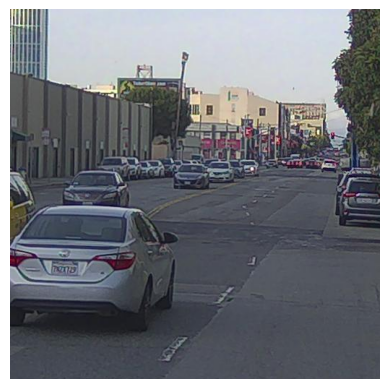

In [24]:
from nerfstudio.generative.utils import show_img


img = batch["image"][0]
img.shape
show_img(img)

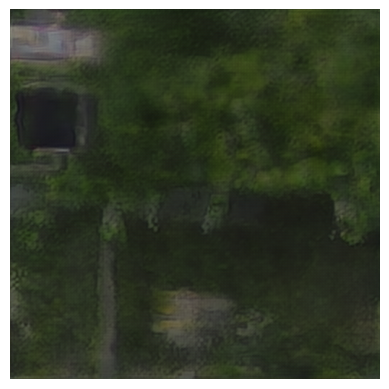

In [139]:
import torch
from copy import deepcopy

with torch.no_grad():
    aug_ray_bundle = augment_ray_bundle(ray_bundle, torch.tensor([0, 0, 0, 0, 0, torch.deg2rad(torch.tensor([-45]))], dtype=torch.float32), pipe.datamanager.train_dataset.cameras)
    aug_outputs = pipe._model(deepcopy(aug_ray_bundle), patch_size=pipe.config.ray_patch_size)

show_img(aug_outputs["rgb"][0])